In this EDA I will perform hierarchical clustering of the scans in the sample subset based on the frequency of pixels with given radiodensitites (binning Hounsfield Units [HU]). I will display a heatmap showing the different frequencies of the HU bins. Finally, we will look to see if the clusters formed distinguish between scans with and without cancer. I do not expect this simple clustering to be able to discriminate between cancerous and non-cancerous scans, especially when performed on this small subset of the data, but it is an exercise to become comfortable with the data type, the Hounsfield Unit scale, and the notion that there will be an association between pixel values and diagnosis. Ultimately, I plan to rely on convolutional neural networks to learn diagnosis from the images.

I will use some of the same pre-processing code which I described in the EDA 1 notebook to read in the DICOM files and convert the pixels to HU. Shout out to Guido Zuidhof for help with the pre-processing code (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial).

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns;
import glob
import re
from pathlib import Path
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../input/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
# This function will load the scan for a given patient and infer the slice thickness for each scan
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
# This function will convert pixels to Hounsfield Units
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices]) #make 3D arrays combining all slices for each patient 
    image = image.astype(np.int16) #convert to int16

    # Pixels that were outside the scanning bounds have been set to -2000
    # Reset to have HU of air = 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept #RescaleIntercept included in metadata of pic
        slope = slices[slice_number].RescaleSlope #RescaleIntercept included in metadata of pic
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Read in each of 20 images and change to HU scale:

In [4]:
allscans = []
allhu = []
for patient in patients:
    patient_scan = load_scan(INPUT_FOLDER + patient)
    allscans.append(patient_scan)
    patient_hu = get_pixels_hu(patient_scan)
    allhu.append(patient_hu)

Flatten each patients scan to a single vector:

In [6]:
flathu = []
for scan in allhu:
    flathu.append(scan.flatten())
    
#take a look at resulting structure
print(len(flathu))
print(flathu[0].shape) #each 3D scan is now represented as a 1D vector

20
(35127296,)


(array([  1.92762510e+07,   8.74920000e+05,   4.94176000e+05,
          9.43424100e+06,   4.42126700e+06,   3.89342000e+05,
          1.43319000e+05,   6.87240000e+04,   2.29990000e+04,
          2.05700000e+03]),
 array([-1024.,  -760.,  -496.,  -232.,    32.,   296.,   560.,   824.,
         1088.,  1352.,  1616.]),
 <a list of 10 Patch objects>)

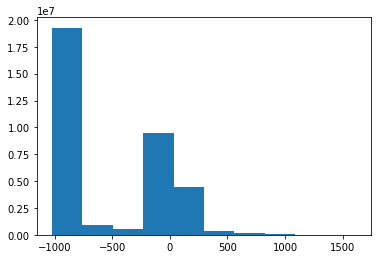

In [7]:
#We can examine a histogram of HU values for one scan to see the distribution of tissue types contained in each pixel
plt.hist(flathu[0])

We will now bin the pixels based on which substance they represent, and then for each patient, derive the frequency of each substance in his or her scan. I used the table provided on  [Wikipedia](http://en.wikipedia.org/wiki/Hounsfield_scale#Value_in_parts_of_the_body) to approximate the substance represented by each bin of HU values, and stored the substance name in the "HU_cats" array below.

In [8]:
#for each image, derive density distribution of HU bins
bins = [-2000, -1100,-750,-250,-5,11,301,701,3000]
HU_cats = ['unknown', 'air', 'lung', 'fat', 'water', 'other soft tissues', 'cancellous bone', 'cortical bone']
HU_hist_data = [] #store the distribution of substances for each scan
for i in range(len(flathu)):
    count, bins = np.histogram(flathu[i], bins)
    freq = count/sum(count)
    #convert from counts to freq
    HU_hist_data.append(freq)


We are now ready to draw our heatmap, which will visualize the densities of the different substances across patient scans, and will also cluster the patients on this density data.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


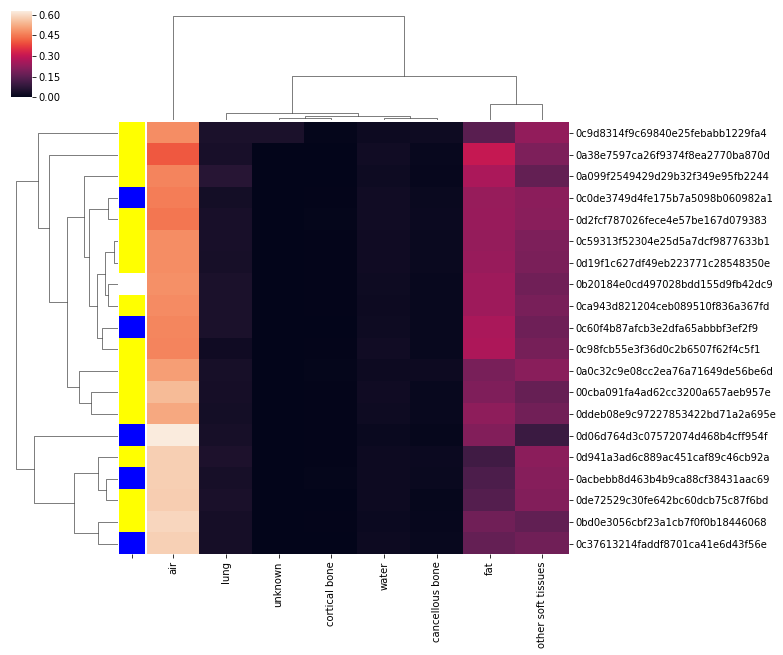

In [9]:
HU_df = pd.DataFrame(HU_hist_data, index = patients, columns = HU_cats)

#read in diagnosis labels (1: cancer, 0: no cancer) to annotate rows in heatmap
diagnoses = pd.read_csv("../input/stage1_labels.csv")

#create color scheme for diagnosis annotation bar in heatmap
color = pd.Series(data = np.array(diagnoses['cancer']), index = diagnoses['id'])
hm_colors = color[patients]
color_map = {0.0: "yellow", 1.0: "blue"}
hm_colors2 = hm_colors.map(color_map)

#draw clustered heatmap
sns.clustermap(HU_df, row_colors= hm_colors2)

In the heatmap above, scans/patients annotated yellow were cancer free, and scans annotated blue received a positive lung cancer diagnosis. As expected, we don't see separation of our two classes of patients (those with lung cancer & those without) when clustering over this density data. From this heatmap, we are able to see that most of the pixels in each scan represent air, followed by fat and other soft tissue, then lung, then water. It makes sense that air is the most abudant substance in the scans, as the lungs are filled with air, and we also forced any pixels outside the cylindrical scanning bounds of the CT machine take on the HU value of air.  It is expected that the general distribution of pixels is not enough information to discern between cancerous and non-cancerous lungs, as the general composition of both classes of scans will be the same. That said, it is possible that if this cluster analysis were run of more images we would see a pattern associated with diagnosis, and it is worth exploring this heatmap with more of the data included.